In [1]:
import pandas
import math
%matplotlib inline

rename_dict = {}
for i in range(1995, 2015):
    rename_dict[' ' + str(i)] = str(i)
    
country_code2country = {}
f = open("who-mortality/country_codes.csv")
f.readline()
for s in f.readlines():
    splitted = s.rstrip().split(',')
    code = splitted[0]
    name = ','.join(splitted[1:])
    country_code2country[int(code)] = name
f.close()

article_subjects = ["genetics", "psychology", "physiology", "molecular"]

sex2int = {"Persons" : 3, "Male" : 1, "Female" : 2}

In [2]:
disease = pandas.read_excel("who-desease-burden/GHE2015_YLD-2015-country.xls", sheet_name=1, header=6)
mortality = pandas.read_csv("who-mortality/mort-no-nan-col.csv")
causes_of_death = pandas.read_csv("who-mortality/causes-of-death.csv", sep=";")


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
articles = pandas.DataFrame()
for subj in article_subjects:
    for year in range(2007, 2016):
        current_frame = pandas.read_excel("scimago-articles/scimago/data/{}/{}.xls".format(subj, year))
        
        current_frame["Year"] = (pandas.Series([year] * len(current_frame)))
        current_frame["Subject"] = (pandas.Series([subj] * len(current_frame)))

        articles = articles.append(current_frame)

In [4]:
i = 0
def choose_last_value(a):
    a, b, c, d = a
    if pandas.notnull(d):
        return d
    elif pandas.notnull(c):
        return c
    elif pandas.notnull(b):
        return b
    return a


In [5]:
mortality["Country"] = mortality["Country"].map(country_code2country.get)

In [6]:
health_exp = pandas.read_csv("who-health-expenditure/exp-years-percent.csv", header=1)
health_exp = health_exp.rename(columns=rename_dict)
health_exp = health_exp.set_index("Country")
health_exp = health_exp.drop(["Bolivia (Plurinational State of)"])
gdp = pandas.read_csv("who-health-expenditure/worldGDP.csv", header = 2)
gdp = gdp.drop(gdp.loc[:, "Country Code": "1990"], axis=1)

del gdp["Unnamed: 62"]
del gdp["2017"] # empty column
gdp = gdp.set_index("Country Name")
gdp.loc["Bolivia (Plurinational State of)"] = gdp.loc["Bolivia"]
gdp.loc["Bahamas"] = gdp.loc["Bahamas, The"]
gdp.loc["Côte d'Ivoire"] = gdp.loc["Cote d'Ivoire"]
gdp.loc["Congo"] = gdp.loc["Congo, Rep."]
gdp.loc["Czechia"] = gdp.loc["Czech Republic"]
gdp.loc["United States of America"] = gdp.loc["United States"]
gdp.loc["Egypt"] = gdp.loc["Egypt, Arab Rep."]
gdp.loc['United Kingdom of Great Britain and Northern Ireland'] = gdp.loc["United Kingdom"]

# different sources differ in countries' names

health_exp_abs_pc = pandas.DataFrame(health_exp).copy()
broken_names = []
for i in health_exp.index:
    for j in health_exp.columns:
        try:
            health_exp_abs_pc.loc[j, i] *= gdp[j][i]
            
            #health_exp_abs_pc.loc[j, i] /= basic["Population (\'000) (2)"][j]
            health_exp_abs_pc.loc[j, i] = math.log(float(health_exp_abs_pc[j][i]))
        except:
            #print(i, j)
            broken_names.append(i)
#'''
set(broken_names)
#sorted([gdp.index[i] if gdp.index[i][0] == '"' else "" for i in range(len(gdp.index))])
#set(gdp.index)

health_exp_abs_pc
#math.log(health_exp_abs_pc.loc["Turkey", "2014"])
#help(math.log)

,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999,1998,1997,1996,1995
Country,,,,,,,,,,,,,,,,,,,,
Afghanistan,12.00,10.59,11.67,10.17,14.40,12.73,6.93,2.95,6.30,5.49,6.98,5.58,8.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,9.37,9.76,9.71,9.85,8.46,8.46,8.37,8.88,9.04,9.67,9.18,7.76,7.19,7.25,7.08,7.19,6.30,6.75,6.63,5.51
Algeria,9.90,9.95,9.99,9.37,9.65,9.01,8.07,8.14,7.80,8.19,8.48,8.50,8.37,8.54,8.79,7.98,8.11,8.25,8.58,8.52
Andorra,27.92,22.32,18.88,19.31,24.04,25.10,24.04,22.85,19.38,19.50,22.70,21.98,19.99,19.24,19.08,20.78,28.70,23.24,23.84,23.56
Angola,5.00,7.42,5.57,5.58,5.43,6.36,6.46,6.42,9.56,6.08,6.25,4.61,3.38,5.77,2.86,2.62,3.29,4.09,2.82,5.18
Antigua and Barbuda,18.08,16.29,17.16,15.18,16.36,11.38,12.27,10.81,10.07,12.08,10.69,11.89,9.88,10.75,11.42,11.85,12.00,12.00,12.00,12.90
Argentina,6.92,7.72,8.74,11.82,14.07,17.13,15.79,15.37,16.35,16.67,16.92,17.27,18.23,17.14,17.59,18.09,17.88,18.03,18.26,19.43
Armenia,7.04,7.27,7.44,7.40,6.97,6.72,7.00,10.42,11.33,10.23,8.02,7.88,7.03,7.66,5.26,6.56,7.68,8.08,8.43,8.30
Australia,17.31,17.31,17.31,17.65,17.11,16.78,17.21,17.48,17.13,16.95,16.95,16.32,16.46,15.70,16.00,15.49,15.28,15.97,15.11,14.92


In [7]:
disease_names = disease.loc[:, "GHE cause":"Member State\n(See Notes for explanation of colour codes)"]
disease["Name"] = disease_names.apply(choose_last_value, axis=1)
basic = disease[disease["GHE cause"].notnull()]
basic["Sex"] = pandas.DataFrame(basic["Sex"].map(sex2int))
basic = basic.drop(basic.loc[:, "Unnamed: 2": "Member State\n(See Notes for explanation of colour codes)"].columns, axis=1)
basic = basic[basic["Sex"].notnull()]
basic = basic.set_index("Name").transpose()

#basic = disease.loc[:, "Afghanistan":"Zimbabwe"][2:15]
#basic = basic.transpose()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Сравнение статистик Китая и Индии

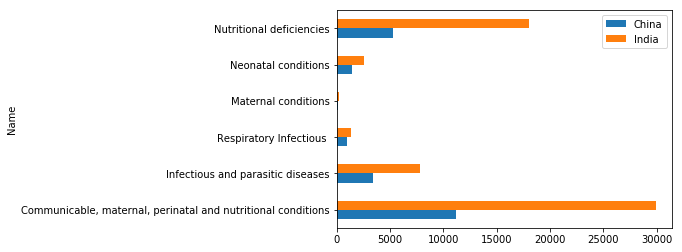

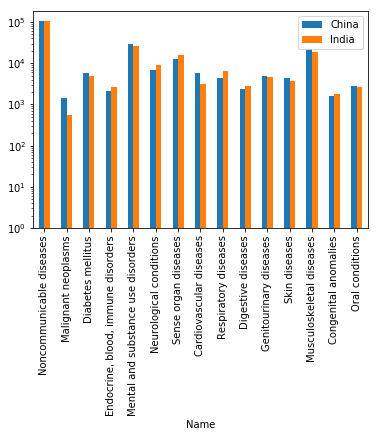

In [8]:
for i in basic.columns:
    try:
        basic[i] = pandas.to_numeric(basic[i])
        basic[i + " r"] = basic[i] / basic["Population (\'000) (2)"] * 1000
    except:
        del basic[i]
        
        


filtered_small = basic[basic.iloc[:, 1] < 100000]
#filtered_small.plot.scatter(x="Population ('000) (2)", y="Digestive diseases")
filtered_large = basic[basic.iloc[:, 1] > 100000].transpose()

filtered_large_comm = filtered_large.iloc[2:8] # all communicable diseases
filtered_large_comm.plot.barh(by = ["China", "India"])

filtered_large_ncomm = filtered_large.loc["Noncommunicable diseases":"Oral conditions"]
filtered_large_ncomm.plot.bar(by = ["China", "India"], log=True)

В Индии население немногим меньше, чем в Китае, в обеих странах более миллиарда жителей. Сравним показатели заболеваемостей.

* Первый график -- заразные заболевания, и на графике видно, что в Индии во всех категориях таких заболеваний больных в 2-4 раза больше.
* Второй график -- незаразные заболевания (логарифмическая шкала, чтобы лучше видеть), здесь совсем другая ситуация, заболевших примерно поровну (всего), но выделяется колонка "Злокачественные новообразования", значение для Китая больше в 3 раза!


## Страны с высокими показателями нек. видов заболеваний

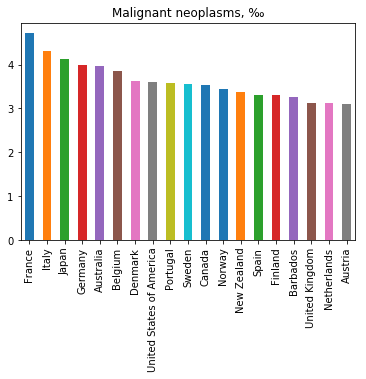

In [9]:
oncology = basic.sort_values(by="Malignant neoplasms r", ascending = False)
max_relative_neoplasms = oncology.iloc[1:20] #first is sex (garbage)
max_relative_neoplasms.plot.bar(by = "", y="Malignant neoplasms r", legend=False, title="Malignant neoplasms, ‰")

Мы видим, что больше всего люди страдают от злокачественных опухолей в продвинутых, экономически благополучных европейских странах. Барбадос?


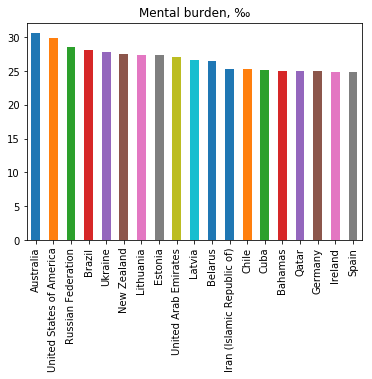

In [10]:
mental_disorders = basic.sort_values(by="Mental and substance use disorders r", ascending = False)
max_relative_mental_burden = mental_disorders.iloc[1:20] #first is sex (garbage)
max_relative_mental_burden.plot.bar(by = "", y="Mental and substance use disorders r", legend=False, title="Mental burden, ‰")

В этом графике очень много стран бывшего Советского Союза по сравнению с предыдущим


#### Исследование влияния вложений бюджета `($ per capita)` на уровень заболеваемости

In [11]:
burden_and_expenditure = (basic.transpose().append(health_exp_abs_pc["2014"])).transpose()
burden_and_expenditure = (burden_and_expenditure.transpose().append(health_exp_abs_pc["2009"])).transpose()

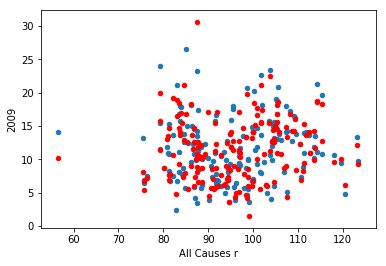

In [12]:
noncomm_expenditure = burden_and_expenditure.plot.scatter(x="All Causes r", y='2014')
burden_and_expenditure.plot.scatter(x="All Causes r", y='2009', ax=noncomm_expenditure, color="red")

Вложения в медицину не дают ощутимого результата, хм.

### Инфекционные заболевания: интересные точки

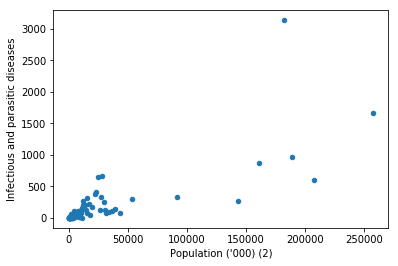

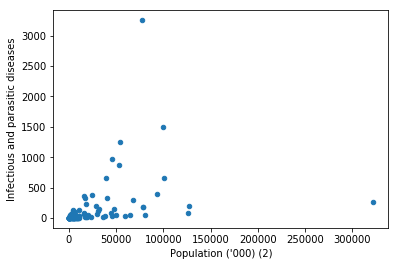

In [13]:
filtered_bae = burden_and_expenditure[burden_and_expenditure["Population (\'000) (2)"] < 1000000]
filtered_bae[10 > filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
filtered_bae[10 <= filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
#filtered_bae

Графики (страны разделены по низкому бюджету медицины и высокому), на которых видим, что в двух странах очень сильные всплески инфекционных заболеваний, что же это за страны?

In [14]:
filtered_bae[filtered_bae["Infectious and parasitic diseases"] > 2000]

Name,Population ('000) (2),All Causes,"Communicable, maternal, perinatal and nutritional conditions",Infectious and parasitic diseases,Respiratory Infectious,Maternal conditions,Neonatal conditions,Nutritional deficiencies,Noncommunicable diseases,Malignant neoplasms,...,Genitourinary diseases r,Skin diseases r,Musculoskeletal diseases r,Congenital anomalies r,Oral conditions r,Injuries r,Unintentional injuries r,Intentional injuries r,2014,2009
Democratic Republic of the Congo,77267.0,8826.190780,4385.637341,3254.203609,117.850021,22.874782,86.007184,904.701745,4103.496904,27.499229,...,2.221148,2.889003,7.077162,0.969804,1.553043,4.362231,3.948021,0.414210,11.06,18.69
Nigeria,182202.0,17221.356446,6259.598770,3137.938561,178.064189,63.141386,217.853307,2662.601328,9833.365459,64.733101,...,2.667187,2.441389,7.835746,0.720120,1.151731,6.193084,5.533613,0.659471,8.17,7.37


Странно, что сюда не попали другие африканские страны

## Научные публикации

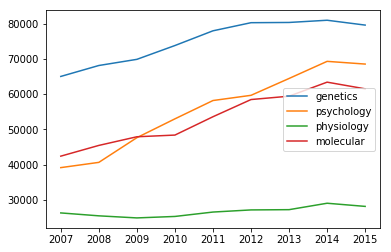

In [20]:
articles_total = pandas.DataFrame()
articles_subject = {}
#artticles[articles["Year"] == year & articles["Subject"] == subj]
for subj in article_subjects:
    #articles_total[subj] = pandas.Series([0] * 10)
    articles_subject[subj] = articles[articles["Subject"] == subj]
    for year in range(2007, 2016):
        articles_total.loc[year, subj] = 0
    for year in range(2007, 2016):
        articles_total.loc[year, subj] += articles_subject[subj][articles_subject[subj]["Year"] == year]["Citable documents"].sum()
        pass
articles_total.plot.line()

export_table = open("articles_stats.html", "w")
print(articles_total.to_html(), file=export_table)
export_table.close()

Как мы видим, количество статей по физиологии почти не меняется, а по остальным 3 из выбранных наук растёт. Хотя количество статей по генетике остановило рост в 2012 году. Странно.

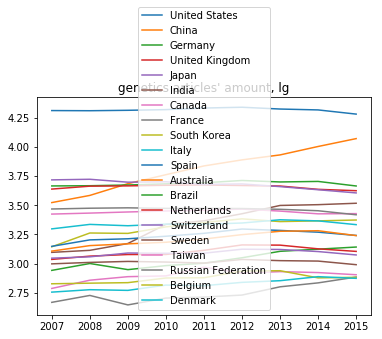

In [16]:
genetics_2015 = articles_subject["genetics"][articles_subject["genetics"]["Year"] == 2015].sort_values("Citable documents", ascending=False)
top_20_g_countries = list(genetics_2015[:20]["Country"])

filtered_top_g = pandas.DataFrame()
for country in top_20_g_countries:
    for year in range(2007, 2016):
        filtered_top_g.loc[year, country] = math.log(articles_subject["genetics"][(articles_subject["genetics"]["Country"] == country) 
                                                                     & (articles_subject["genetics"]["Year"] == year)]["Citable documents"].iloc[0], 10)
        

filtered_top_g.plot.line(title="genetics articles' amount, lg") # TODO нормально это нарисовать ?!

Можем увидеть, что из США выходит наибольшее количество статей по генетике. Тем не менее, в последние годы их количество начало снижаться (с 2012, как раз, когда на пред. графике закончился рост), а количество статей из Китая быстро увеличивается. Если приглядеться, ещё значительный рост количества статей наблюдается у Швеции.